In [2]:
import numpy as np
import scipy.signal as signal
import pandas as pd
from wfdb import processing
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os

In [25]:
class ECGSignal():
    def __init__(self, ecg_signal, Fs=1000, lowcut=0.3, highcut=60, resample_fs=128):
        self.ecg_signal = ecg_signal
        self.Fs = Fs
        self.lowcut = lowcut
        self.highcut = highcut
        self.resample_fs = resample_fs

        self.filtered_ecg_signal = self.apply_filter_to_signal()
        self.resampled_ecg_signal = signal.resample(self.filtered_ecg_signal, (len(self.ecg_signal) // self.Fs) * self.resample_fs)

        self.conf = processing.XQRS.Conf(ref_period=0.4)
        self.xqrs = processing.XQRS(sig=ecg_signal, fs=Fs, conf=self.conf)
        self.xqrs.detect(learn=False)
        peaks = self.xqrs.qrs_inds / Fs
        self.RRI = np.diff(peaks)

    def get_rri(self):
        return self.RRI

    def butter_bandpass(self, order=4):
    # to gain paramaters of butterworth bandpass filter
        nyq = 0.5 * self.Fs
        low = self.lowcut / nyq
        high = self.highcut / nyq
        b, a = signal.butter(order, [low, high], btype='band')
        return b, a

    def apply_filter_to_signal(self, order=4):
    # apply butterworth bandpass filter to the signal
        b, a = self.butter_bandpass(order)
        filtered = signal.filtfilt(b, a, self.ecg_signal)
        return filtered

In [21]:
def csv_to_signal(filepath, header=None, skiprows=13):
    ecg_df = pd.read_table(filepath, header=header, skiprows=skiprows)[0]
    ecg_signal = ecg_df.values

    return ecg_signal

In [23]:
def main():
    filepath = '../data/WAV_00000010.txt'
    # if not os.path.exists(filepath):
    #     exit()

    Fs = 1000  # [Hz]
    # High cht freq: 30 [Hz]
    s = csv_to_signal(filepath)

    ecg_signal = ECGSignal(s)
    rri = ecg_signal.get_rri()

    # plt.plot(ecg_signal)
    # plt.show()

if __name__ == '__main__':
    main()

[ 0.     0.     0.    ... -0.006 -0.006 -0.006]
Initializing using default parameters
Running QRS detection...
QRS detection complete.


In [24]:
filepath = '../data/WAV_00000010.txt'
    # if not os.path.exists(filepath):
    #     exit()
Fs = 1000  # [Hz]
    # High cht freq: 30 [Hz]
s = csv_to_signal(filepath)

ecg_signal = ECGSignal(s)
rri = ecg_signal.get_rri()

[ 0.     0.     0.    ... -0.006 -0.006 -0.006]
Initializing using default parameters
Running QRS detection...
QRS detection complete.


In [50]:
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values

rri_int = list(map(int, rri * 1000))

# This remove outliers from signal
rr_intervals_without_outliers = remove_outliers(rr_intervals=rri_int,                                                     low_rri=300, high_rri=2000)

# This replace outliers nan values with linear interpolation
interpolated_rr_intervals = interpolate_nan_values(rr_intervals=rr_intervals_without_outliers, interpolation_method="linear")

# This remove ectopic beats from signal
nn_intervals_list = remove_ectopic_beats(rr_intervals=interpolated_rr_intervals, method="malik")
# This replace ectopic beats nan values with linear interpolation
interpolated_nn_intervals = interpolate_nan_values(rr_intervals=nn_intervals_list)



0 outlier(s) have been deleted.
2 ectopic beat(s) have been deleted with malik rule.


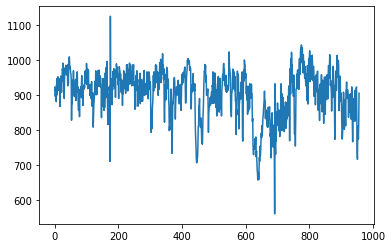

In [53]:
plt.plot(rri_int)

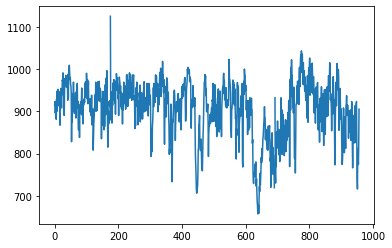

In [52]:
plt.plot(nn_intervals_list)

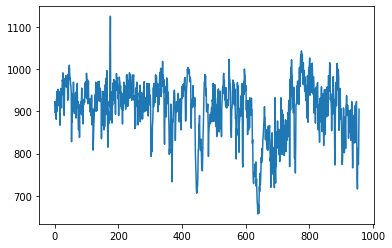

In [61]:
plt.plot(interpolated_nn_intervals)

In [ ]:
from hrvanalysis import remove_outliers, remove_ectopic_beats, 

def preprocess_hrvanalysis(rri, low_rri=300, high_rri=2000, interpolation_method='linear', ectopicbeats_method='malik')

    rri_int = list(map(int, rri * 1000))

    # This remove outliers from signal
    rr_intervals_without_outliers = remove_outliers(rr_intervals=rri_int,                                                     low_rri=300, high_rri=2000)

    # This replace outliers nan values with linear interpolation
    interpolated_rr_intervals = interpolate_nan_values(rr_intervals=rr_intervals_without_outliers, interpolation_method="linear")

    # This remove ectopic beats from signal
    nn_intervals_list = remove_ectopic_beats(rr_intervals=interpolated_rr_intervals, method="malik")
    # This replace ectopic beats nan values with linear interpolation
    interpolated_nn_intervals = interpolate_nan_values(rr_intervals=nn_intervals_list)

    return nn_intervals_list, interpolated_nn_intervals

In [ ]:
def calc_hrv_features(nn_intervals):
    time_domain_features = get_time_domain_features(nn_intervals)
    frequency_features = get_frequency_domain_features(nn_intervals)

    return time_domain_features, frequency_features

In [ ]:
main

In [62]:
from hrvanalysis import get_time_domain_features, get_frequency_domain_features

time_domain_features = get_time_domain_features(interpolated_nn_intervals)
frequency_features = get_frequency_domain_features(interpolated_nn_intervals)

print(time_domain_features)
print(frequency_features)

{'mean_nni': 905.3077324973876, 'sdnn': 66.86310894383749, 'sdsd': 43.83730876098375, 'nni_50': 242, 'pnni_50': 25.313807531380753, 'nni_20': 613, 'pnni_20': 64.1213389121339, 'rmssd': 43.837309771853846, 'median_nni': 917.0, 'range_nni': 468.0, 'cvsd': 0.04842255091638725, 'cvnni': 0.07385677438034081, 'mean_hr': 66.67103732039844, 'max_hr': 91.32420091324201, 'min_hr': 53.333333333333336, 'std_hr': 5.389877671600822}
{'lf': 863.0448426010049, 'hf': 336.0689207451315, 'lf_hf_ratio': 2.568059077547139, 'lfnu': 71.97355822125428, 'hfnu': 28.026441778745703, 'total_power': 2220.3933121405516, 'vlf': 1021.2795487944154}


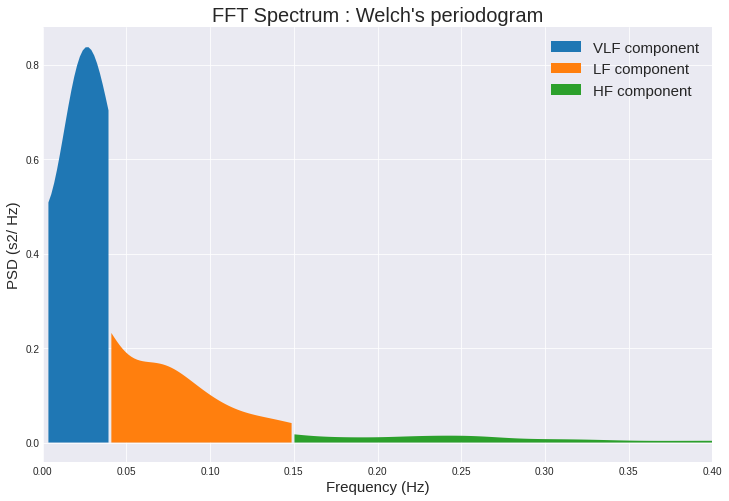

In [69]:
from hrvanalysis import plot_psd, plot_distrib
plot_psd(interpolated_nn_intervals, method="welch")

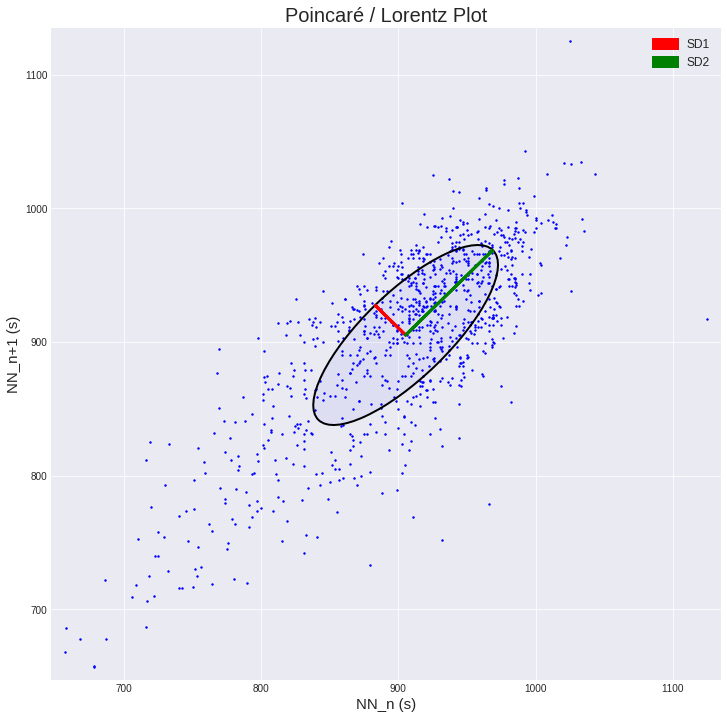

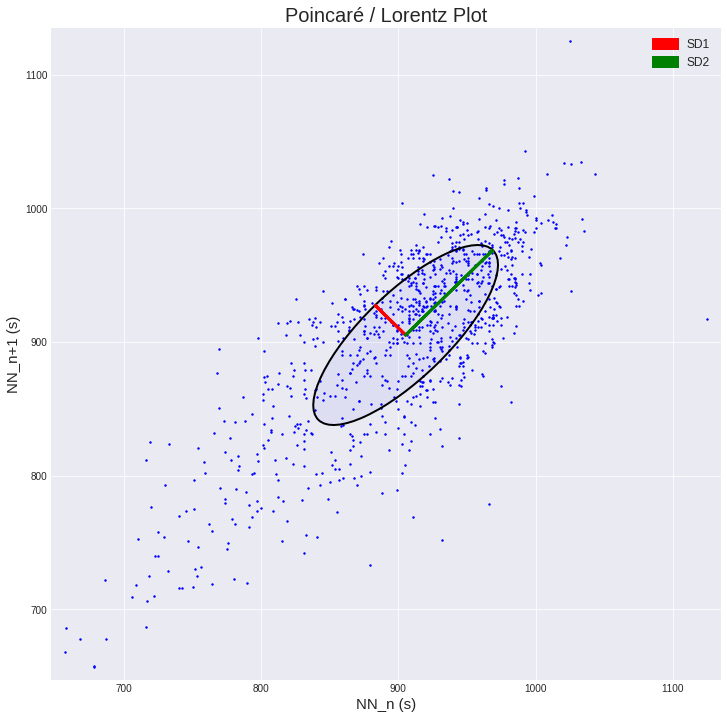

In [70]:
from hrvanalysis import plot_poincare

plot_poincare(interpolated_nn_intervals)
plot_poincare(interpolated_nn_intervals, plot_sd_features=True)

In [ ]:
class RRI():
    def __init__(self, rri):
        self.rri = rri

    def calc_windowed_hrv(self, window, step)
        num_window = (self.rri[-1] - window) // step + 1
        hrvs = []
        for w in range(num_window):
            start = w * step
            end = window + w * step
            windowed_rri = self.rri[start < self.rri and self.rri < end]
            hrvs.append(calc_hrvs(windowed_rri))
        return hrvs

    def calc_hrvs(self, rris):
        return []

    
    def _mean_hr(self):
        pass

    def _mean_rr(self):
        pass

    def _sdnn(self):
        pass
    
    def _cv(self):
        pass
    
    def _rmssd(self):
        pass
    
    def _pnn50(self):
        pass

    def _lf(self):
        pass

    def _hf(self):
        pass
    
    def _lfhf(self):
        pass

    